# Indentation Analysis Script

The Jupyter notebook presented here aims to introduce students to the analysis of nanoindentation curves and on the general way to write Python scripts to analyse data.
The main parts are the following:
1. Description of the script
2. Imports of the different modules
3. Functions definitions
4. Data analysis

# Initialization

In general, it is good practice to write a brief description of the overall purpose or use of the script. Additionaly, the version of the script can also be writen here. When important modifications are realised, the author can increment the script version and describe the added modifications.

In [15]:
# Initialization

Version = '01'

Description = """
    Script used for performing the indentation analysis
    during the BME Labs

    Version Control:
        01 - Original script

    Author: Mathieu Simon
            ARTORG Center for Biomedical Engineering Research
            SITEM Insel, University of Bern

    Date: February 2024
    """

# Modules Import

The second part consist in importing the different modules/packages or functions needed for the execution of the script. Using modules usually helps a lot in simplifying the readability of the script

In [16]:
# Modules import

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
from scipy.stats.distributions import t


# Functions Definition

However, sometimes it is easier to write custom functions for the targeted purpose. These functions also avoid to repeat part of the code used at different places. It is also a good practice to write a short description of what the function is doing. To additionaly help to the understanding of the function, the type of inputs can be precised as well as the type of the returned objects.

In [17]:
# Define functions

def PlotIndents(Curves:pd.DataFrame, Bad=[]) -> None:

    """
    Plot indentation force and displacement with
    respect to time and force-displacement curves

    Parameters
    ----------
    Curves: Data frame containing time, force and displacement measurement
    Bad: List of indents with abnormal behavior

    Returns
    -------
    None
    """

    # Get indents list and remove bad ones if any
    Indents = list(set([C[0] for C in Curves.columns]))

    if len(Bad) > 0:
        IndentsNumbers = [int(I[6:]) for I in Indents]
        IndentsIndices = [IndentsNumbers.index(B) for B in Bad]
        BadIndents = [Indents.pop(I) for I in IndentsIndices]

    # Plot results
    Figure, Axis = plt.subplots(1,2,dpi=96, figsize=(10,4))
    Axis2 = Axis[0].twinx()

    # Plot each indent
    
    for I in Indents:

        # Get data of the corresponding indent
        Time = Curves[I]['Time (s)']
        Force = Curves[I]['Force (mN)']
        Displacement = Curves[I]['Displacement (nm)']

        # Plot force and displacement with respect to time
        Axis[0].plot(Time, Force, color=(0,0,1))
        Axis2.plot(Time, Displacement, color=(1,0,0))

        # Plot force-displacements curves
        Axis[1].plot(Displacement, Force, color=(0,0,0))

    # Highlight selected bad indents
    if len(Bad) > 0:
        for B in BadIndents:

            # Get data of the corresponding indent
            Time = Curves[B]['Time (s)']
            Force = Curves[B]['Force (mN)']
            Displacement = Curves[B]['Displacement (nm)']

            # Plot force and displacement with respect to time
            Axis[0].plot(Time, Force, color=(0,0,1), linestyle='--')
            Axis2.plot(Time, Displacement, color=(1,0,0), linestyle='--')

            # Plot force-displacements curves
            Axis[1].plot(Displacement, Force, color=(0,0,0), linestyle='--')
    
    # Set axes labels
    Axis[0].set_xlabel('Time (s)')
    Axis[0].set_ylabel('Force (mN)', color=(0,0,1))
    Axis2.set_ylabel('Displacement (nm)', color=(1,0,0))
    Axis[1].set_xlabel('Displacement (nm)')
    Axis[1].set_ylabel('Force (mN)')

    # Show results
    Figure.tight_layout()
    plt.savefig('Indents',dpi=196)
    plt.show(Figure)

    return

def ComputeEpsilon(m:float) -> float:

    """
    Compute the value of the epsilon factor using reference values and
    linear interpolation

    Based on:
    Woirgard, J., Dargenton, J.-C., Tromas, C., & Audurier, V. (1998).
    A new technology for nanohardness measurements: principle and applications.
    In Surface and Coatings Technology (Vol. 100, Issue 101).

    Parameters
    ----------
    m: Coefficient obtained from the least square fitting using Oliver and Pharr method

    Returns
    -------
    Epsilon: Geometric coefficient used to compute hc
    """

    mValues = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5,
                1.6, 1.7, 1.8, 1.9, 2.0]
    EValues = [1.000, 0.829, 0.793, 0.772, 0.759, 0.750,
                0.743, 0.738, 0.733, 0.730, 0.727]

    Round = round(m-0.05,1)

    if Round >= 2.0:
        Epsilon = EValues[-1]
    else:
        Idx = mValues.index(Round)
        Delta = m - Round
        Epsilon = EValues[Idx] + Delta * (EValues[Idx+1] - EValues[Idx])

    return Epsilon

def ProjectedArea(hc:float) -> float:

    """
    Compute projected contact area for Berkovich indenter
    Formula from the machine (look like a Taylor serie)

    Parameters
    ----------
    hc: Contact depth of the indenter with the sample at Fmax

    Returns
    -------
    Ap: Computed projected area
    """

    # if hc > 165:
        # print("hc out of tip calibration !")

    Ap = 24.5 * hc**2
    Ap -= 860 * hc
    Ap += 2.01E005 * hc**(1/2)
    Ap -= 2.05E006 * hc**(1/4)
    Ap += 5.13E006 * hc**(1/8)
    Ap -= 3.30E006 * hc**(1/16)

    return Ap

def BoxPlot(ArraysList, Labels=['', 'Y'], SetsLabels=None, TTest=False, FName='BoxPlot') -> None:

    """
    Draw boxplot of the given arrays. Labels can be added to the axis and different sets.
    Additionally, a t-test can be performed between the successive arrays


    Parameters
    ----------
    ArraysList: List of different arrays to draw boxplots
    Labels: Labels of the axis (horizontal and vertical)
    SetsLabels: Labels for the different sets, will be displayed under the different boxes
    TTest: Boolean, if a t-test between the successive arrays must be performed or not
    FName: Figure name (to save it)

    Returns
    -------
    None
    """

    Figure, Axis = plt.subplots(1,1, figsize=(5.5, 4.5), dpi=96)

    for i, Array in enumerate(ArraysList):
        RandPos = np.random.normal(i,0.02,len(Array))

        Axis.boxplot(Array, vert=True, widths=0.35,
                    showmeans=False,meanline=True,
                    showfliers=False, positions=[i],
                    capprops=dict(color=(0,0,0)),
                    boxprops=dict(color=(0,0,0)),
                    whiskerprops=dict(color=(0,0,0),linestyle='--'),
                    medianprops=dict(color=(0,0,1)),
                    meanprops=dict(color=(0,1,0)))
        Axis.plot(RandPos - RandPos.mean() + i, Array, linestyle='none',
                    marker='o',fillstyle='none', color=(1,0,0))
        
    if TTest == True:
        for i, A in enumerate(ArraysList[:-1]):
            T_Tests = ttest_ind(np.array(A,float), np.array(ArraysList[i+1],float))
            YLine = 1.05 * max(A.max(), ArraysList[i+1].max())
            Axis.plot([i+0.05, i+0.95], [YLine, YLine], color=(0,0,0), marker='|',linewidth=0.5)
            
            # Mark significance level
            if T_Tests[1] < 0.001:
                Text = '***'
            elif T_Tests[1] < 0.01:
                Text = '**' 
            elif T_Tests[1] < 0.05:
                Text = '*'
            else:
                Text = 'n.s.'
            Axis.annotate(Text, xy=[i+0.5, 0.985*YLine], ha='center')

            # Write confidence interveal
            CIl = round(T_Tests.confidence_interval()[0],1)
            CIu = round(T_Tests.confidence_interval()[1],1)
            Text = 'CI (' + str(CIl) + ',' + str(CIu) + ')'
            Axis.annotate(Text, xy=[i+0.5, 1.005*YLine], ha='center')
            Axis.set_ylim([0.95*min([min(A)for A in ArraysList]), YLine*1.05])
    
    Axis.plot([],linestyle='none',marker='o',fillstyle='none', color=(1,0,0), label='Data')
    Axis.plot([],color=(0,0,1), label='Median')
    Axis.set_xlabel(Labels[0])
    Axis.set_ylabel(Labels[1])

    if SetsLabels:
        Axis.set_xticks(np.arange(len(SetsLabels)))
        Axis.set_xticklabels(SetsLabels, rotation=0)
    else:
        Axis.set_xticks([])
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=2)
    plt.subplots_adjust(left=0.25, right=0.75, top=0.9)
    plt.savefig(FName, dpi=196)
    plt.show(Figure)

    return

def OLS(X:np.array, Y:np.array, Labels=None, Alpha=0.95, FName='OLS') -> None:
    
    """
    Plot linear regression between to variables X and Y


    Parameters
    ----------
    X: Independent variable
    Y: Dependent variable
    Labels: Labels for the different axes/variables (X and Y)
    Alpha: Conficence level
    FName: Figure name (to save it)

    Returns
    -------
    None
    """

    if Labels == None:
        Labels = ['X', 'Y']
    
    # Perform linear regression
    Xm = np.matrix([np.ones(len(X)), X]).T
    Ym = np.matrix(Y).T
    Intercept, Slope = np.linalg.inv(Xm.T * Xm) * Xm.T * Ym
    Intercept = np.array(Intercept)[0,0]
    Slope = np.array(Slope)[0,0]

    # Build arrays and matrices
    Y_Obs = Y
    Y_Fit = X * Slope + Intercept
    N = len(Y)
    X = np.matrix(X)

    # Sort X values and Y accordingly
    Sort = np.argsort(np.array(Xm[:,1]).reshape(len(Xm)))
    X_Obs = np.sort(np.array(Xm[:,1]).reshape(len(Xm)))
    Y_Fit = Y_Fit[Sort]
    Y_Obs = Y_Obs[Sort]

    ## Compute R2 and standard error of the estimate
    E = Y_Obs - Y_Fit
    RSS = np.sum(E ** 2)
    SE = np.sqrt(RSS / (N - 2))
    TSS = np.sum((Y - np.mean(Y)) ** 2)
    RegSS = TSS - RSS
    R2 = RegSS / TSS
    R2adj = 1 - RSS/TSS * (N-1)/(N-Xm.shape[1]+1-1)

    ## Compute variance-covariance matrix
    C = np.linalg.inv(Xm.T * Xm)

    ## Compute CI lines
    B_0 = np.sqrt(np.diag(np.abs(Xm * C * Xm.T)))
    t_Alpha = t.interval(Alpha, N - Xm.shape[1] - 1)
    CI_Line_u = Y_Fit + t_Alpha[0] * SE * B_0[Sort]
    CI_Line_o = Y_Fit + t_Alpha[1] * SE * B_0[Sort]

    ## Plots
    DPI = 96
    Figure, Axes = plt.subplots(1, 1, figsize=(5.5, 4.5), dpi=DPI)
    Axes.plot(X_Obs, Y_Obs, linestyle='none', marker='o', color=(0,0,1), fillstyle='none')
    Axes.plot(X_Obs, Y_Fit, color=(1,0,0))
    Axes.fill_between(X_Obs, CI_Line_o, CI_Line_u, color=(0, 0, 0), alpha=0.1)

    # Add annotations
    if Slope > 0:

        # Number of observations
        YPos = 0.925
        Axes.annotate(r'$N$  : ' + str(N), xy=(0.025, YPos), xycoords='axes fraction')

        # Pearson's correlation coefficient
        YPos -= 0.075
        Axes.annotate(r'$R^2$ : ' + format(round(R2, 2), '.2f'), xy=(0.025, YPos), xycoords='axes fraction')

        # Standard error of the estimate
        YPos -= 0.075
        Axes.annotate(r'$SE$ : ' + format(round(SE, 2), '.2f'), xy=(0.025, YPos), xycoords='axes fraction')
        
        # Intercept coeffecient and corresponding confidence interval
        YPos = 0.025
        Round = 3 - str(Intercept).find('.')
        rIntercept = np.round(Intercept, Round)
        CIMargin = t_Alpha[1] *  np.sqrt(RSS / (N - 2) * C[0,0])
        CI = np.round([Intercept - CIMargin, Intercept + CIMargin], Round)
        if Round <= 0:
            rIntercept = int(rIntercept)
            CI = [int(v) for v in CI]
        Text = r'Intercept : ' + str(rIntercept) + ' (' + str(CI[0]) + ',' + str(CI[1]) + ')'
        Axes.annotate(Text, xy=(0.5, YPos), xycoords='axes fraction')
        YPos += 0.075

        # Slope coeffecient and corresponding confidence interval
        Round = 3 - str(Slope).find('.')
        rSlope = np.round(Slope, Round)
        CIMargin = t_Alpha[1] * np.sqrt(RSS / (N - 2) * C[1,1])
        CI = np.round([Slope - CIMargin, Slope + CIMargin], Round)
        if Round <= 0:
            rSlope = int(rSlope)
            CI = [int(v) for v in CI]
        Text = r'Slope : ' + str(rSlope) + ' (' + str(CI[0]) + ',' + str(CI[1]) + ')'
        Axes.annotate(Text, xy=(0.5, YPos), xycoords='axes fraction')

    elif Slope < 0:

        # Number of observations
        YPos = 0.025
        Axes.annotate(r'$N$  : ' + str(N), xy=(0.025, YPos), xycoords='axes fraction')

        # Pearson's correlation coefficient
        YPos += 0.075
        Axes.annotate(r'$R^2$ : ' + format(round(R2, 2), '.2f'), xy=(0.025, YPos), xycoords='axes fraction')

        # Standard error of the estimate
        YPos += 0.075
        Axes.annotate(r'$SE$ : ' + format(round(SE, 2), '.2f'), xy=(0.025, YPos), xycoords='axes fraction')

        # Intercept coeffecient and corresponding confidence interval
        YPos = 0.925
        Round = 3 - str(Intercept).find('.')
        rIntercept = np.round(Intercept, Round)
        CIMargin = t_Alpha[1] * np.sqrt(RSS / (N - 2) * C[0,0])
        CI = np.round([Intercept - CIMargin, Intercept + CIMargin],Round)
        if Round <= 0:
            rIntercept = int(rIntercept)
            CI = [int(v) for v in CI]
        Text = r'Intercept : ' + str(rIntercept) + ' (' + str(CI[0]) + ',' + str(CI[1]) + ')'
        Axes.annotate(Text, xy=(0.5, YPos), xycoords='axes fraction')
        YPos -= 0.075

        # Slope coeffecient and corresponding confidence interval
        Round = 3 - str(Slope).find('.')
        rSlope = np.round(Slope, Round)
        CIMargin = t_Alpha[1] * np.sqrt(RSS / (N - 2) * C[1,1])
        CI = np.round([Slope - CIMargin, Slope + CIMargin],Round)
        if Round <= 0:
            rSlope = int(rSlope)
            CI = [int(v) for v in CI]
        Text = r'Slope : ' + str(rSlope) + ' (' + str(CI[0]) + ',' + str(CI[1]) + ')'
        Axes.annotate(Text, xy=(0.5, YPos), xycoords='axes fraction')
    
    Axes.set_xlabel(Labels[0])
    Axes.set_ylabel(Labels[1])
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.savefig(FName, dpi=196)
    plt.show(Figure)

    return

# Data Analysis

The main script with the different analyses performed. For clarity, it is advised to write short lines of code and add meaningful comments.

In [18]:
# List curve files
CWD = Path.cwd()
Files = sorted([F for F in CWD.iterdir() if F.name.endswith('.TXT')])
for F in Files:
    print(F.name)

DummySample1.TXT
DummySample2.TXT


In [19]:
# Select example file to read (in Python, indexing starts at 0)
Sample1 = 'DummySample1.TXT'
Sample2 = 'DummySample2.TXT'

Curves1 = pd.read_csv(Sample1, sep='\t')
Curves2 = pd.read_csv(Sample2, sep='\t')

for i, C in enumerate([Curves1, Curves2]):

    # Compute number of indents
    Columns = C.columns
    NIndents = (len(Columns) - 1) // 4

    # Filter to keep relevants columns only
    ColIdx = [0,1,3]
    Shifts = np.repeat(np.arange(NIndents)*4,3)
    Cols2Keep = np.tile(ColIdx, NIndents) + Shifts
    C = C[Columns[Cols2Keep]]

    # Reset columns header with something more meaningful
    ColNames = ['Time (s)', 'Force (mN)','Displacement (nm)']
    Indents = ['Indent ' + str(i+1) for i in range(NIndents)]
    Headers = pd.MultiIndex.from_product([Indents, ColNames])
    C.columns = Headers

    if i == 0:
        Curves1 = C
    else:
        Curves2 = C

Curves1

Indent 1                              Indent 2             \
    Time (s) Force (mN) Displacement (nm) Time (s) Force (mN)   
0        0.0   0.000000          0.000000      0.0   0.000000   
1        0.1   0.146184         32.923222      0.1   0.146580   
2        0.2   0.320738         58.918317      0.2   0.318320   
3        0.3   0.492220         80.309642      0.3   0.490343   
4        0.4   0.661893         98.567198      0.4   0.661584   
..       ...        ...               ...      ...        ...   
337     32.7  -0.050686       -536.397342     33.7  -0.043074   
338     32.7  -0.050686       -536.397342     33.8  -0.042864   
339     32.7  -0.050686       -536.397342     33.9  -0.042961   
340     32.7  -0.050686       -536.397342     34.0  -0.042616   
341     32.7  -0.050686       -536.397342     34.1  -0.043254   

                      Indent 3                              Indent 4  ...  \
    Displacement (nm) Time (s) Force (mN) Displacement (nm) Time (s)  ...   
0            0.000000      0.0   0.000000          0.000000      0.0  ...   
1           31.859663      0.1   0.146799         34.337427      0.1  ...   
2           59.030144      0.2   0.320299         61.675096      0.2  ...   
3           81.414346      0.3   0.491695         83.044220      0.3  ...   
4          100.234247      0.4   0.664955        101.686778      0.4  ...   
..                ...      ...        ...               ...      ...  ...   
337       -505.079638     32.7  -0.044185       -182.618951     33.2  ...   
338       -512.413744     32.7  -0.044185       -182.618951     33.2  ...   
339       -519.085106     32.7  -0.044185       -182.618951     33.2  ...   
340       -527.052789     32.7  -0.044185       -182.618951     33.2  ...   
341       -534.166779     32.7  -0.044185       -182.618951     33.2  ...   

            Indent 15 Indent 16                              Indent 17  \
    Displacement (nm)  Time (s) Force (mN) Displacement (nm)  Time (s)   
0            0.000000       0.0   0.000000          0.000000       0.0   
1           35.951648       0.1   0.149984         37.659747       0.1   
2           62.695758       0.2   0.324453         65.989734       0.2   
3           84.566318       0.3   0.496487         88.686543       0.3   
4          103.961402       0.4   0.667328        108.634249       0.4   
..                ...       ...        ...               ...       ...   
337        326.216305      30.9  -0.033228      -1379.249716      32.9   
338        326.216305      30.9  -0.033228      -1379.249716      32.9   
339        326.216305      30.9  -0.033228      -1379.249716      32.9   
340        326.216305      30.9  -0.033228      -1379.249716      32.9   
341        326.216305      30.9  -0.033228      -1379.249716      32.9   

                                 Indent 18                               
    Force (mN) Displacement (nm)  Time (s) Force (mN) Displacement (nm)  
0     0.000000          0.000000       0.0   0.000000          0.000000  
1     0.148152         27.842202       0.1   0.148688         26.823172  
2     0.318617         51.354800       0.2   0.319236         49.381824  
3     0.488318         72.451144       0.3   0.490090         69.260218  
4     0.659400         91.290408       0.4   0.659371         87.206936  
..         ...               ...       ...        ...               ...  
337  -0.051488        339.431094      32.8  -0.048542         95.267324  
338  -0.051488        339.431094      32.8  -0.048542         95.267324  
339  -0.051488        339.431094      32.8  -0.048542         95.267324  
340  -0.051488        339.431094      32.8  -0.048542         95.267324  
341  -0.051488        339.431094      32.8  -0.048542         95.267324  

[342 rows x 54 columns]

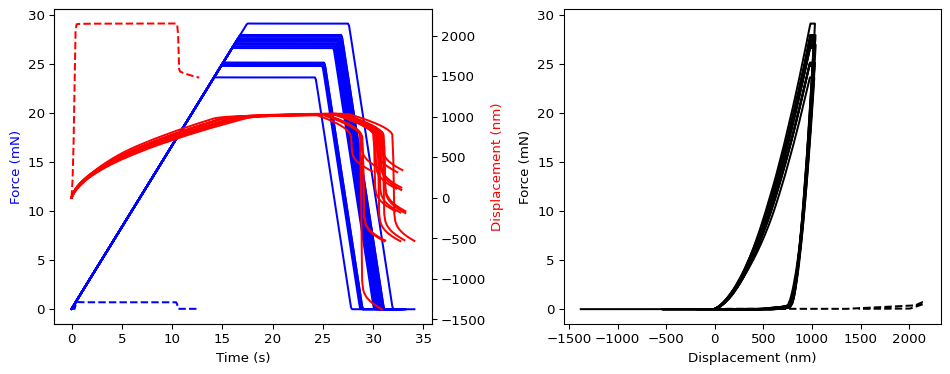

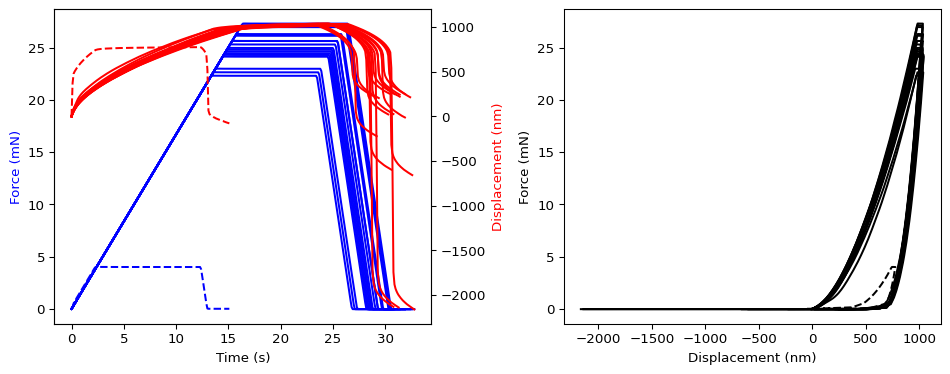

In [20]:
# Select curves to show and define bad indents (if any)
Bad1 = [14]
Bad2 = [4]

PlotIndents(Curves1, Bad1)
PlotIndents(Curves2, Bad2)

In [21]:
# Remove bad indents from analysis
Curves1 = Curves1.drop(columns=['Indent ' + str(B) for B in Bad1], level=0)
Curves2 = Curves2.drop(columns=['Indent ' + str(B) for B in Bad2], level=0)
Indents1 = np.unique([C[0] for C in Curves1.columns])
Indents2 = np.unique([C[0] for C in Curves2.columns])

# Oliver and Pharr methods

The method proposed by Oliver and Pharr to estimate indentation modulus is based on the assumption that the first part of the unloading curve is purely elastic. It was shown that the unloading curve can be described using a power law of the type:

$F = F_{max} \left( \frac{h - h_p}{h_{max} - hp} \right)^m $

Where $F$ is the force, $F_{max}$ is the maximum force, $h$ is the displacement, $h_{max}$ is the maximum displacement, $h_p$ is the permanent indentation depth, and $m$ if a fitting parameter. So the idea is to fit $m$, $h_{max}$ and $h_p$ of this power law to the upper part of the unloading curve using a least square scheme.

To do so, we detect the maximum displacement and get the corresponding force. Then, we select the unloading part in between 98% and 40% of the maximum force. The fitting is performed in 2 steps. The first step fits the power law using only $h_p$ and $m$ as parameters and $h_{max}$ as an input. The idea here is to have initial guess values for the curve fitting. In second step, the fit is performed again but this time with  $m$, $h_p$ and $h_{max}$ as parameters.

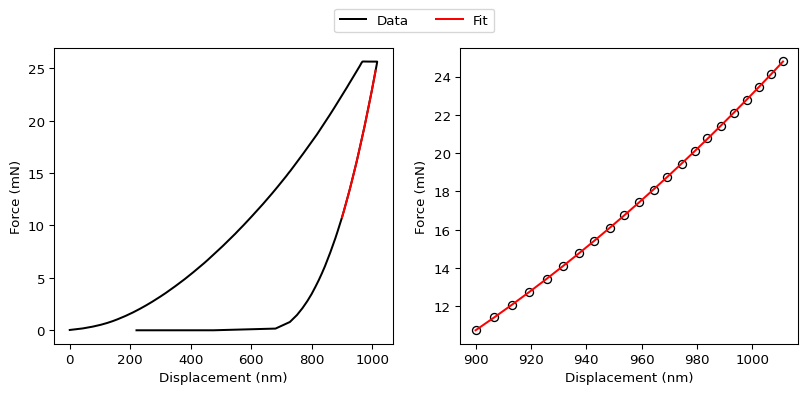

In [22]:
# Loop over each indent to get hmax, hp, and m

FMAX1, HMAX1, HP1, M1 = [], [], [], []
FMAX2, HMAX2, HP2, M2 = [], [], [], []

for iC, Curves in enumerate([Curves1, Curves2]):

    if iC == 0:
        Indents = Indents1
    else:
        Indents = Indents2

    for I in Indents:

        # Select data for curve fitting
        Idx = Curves[I]['Displacement (nm)'].idxmax()
        FMax = Curves[I].loc[Idx,'Force (mN)']
        hMax = Curves[I].loc[Idx,'Displacement (nm)']
        F1 = Curves[I].iloc[Idx:]['Force (mN)'] < 0.98 * FMax
        F2 = Curves[I].iloc[Idx:]['Force (mN)'] > 0.40 * FMax
        X = Curves[I].iloc[Idx:][F1*F2]['Displacement (nm)']
        Y = Curves[I].iloc[Idx:][F1*F2]['Force (mN)']

        # Initial parameters guess
        def OliverAndPharrGuess(h, hp, m):
            return FMax * ((h - hp) / (hMax - hp))**m

        [hp, m], Pcov = curve_fit(OliverAndPharrGuess, X, Y)

        # Fit parameters using least squares regresion
        def OliverAndPharr(h, hmax, hp, m):
            return FMax * ((h - hp) / (hmax - hp))**m

        [hmax, hp, m], Pcov = curve_fit(OliverAndPharr, X, Y, p0=(hMax, hp, m))

        # Store variables into lists
        if iC == 0:
            FMAX1.append(FMax)
            HMAX1.append(hmax)
            HP1.append(hp)
            M1.append(m)
        else:
            FMAX2.append(FMax)
            HMAX2.append(hmax)
            HP2.append(hp)
            M2.append(m)

# Plot results of the last fit for example purpose
Figure, Axis = plt.subplots(1,2,dpi=96,figsize=(10,4))

# Full force-displacement curve with fit
Axis[0].plot(Curves[I]['Displacement (nm)'], Curves[I]['Force (mN)'], color=(0,0,0),label='Data')
Axis[0].plot(X, OliverAndPharr(X, hmax, hp, m), color=(1,0,0), label='Fit')

# Zoom over fit region
Axis[1].plot(X, Y, color=(0,0,0), marker='o', linestyle='none', fillstyle='none')
Axis[1].plot(X, OliverAndPharr(X, hmax, hp, m), color=(1,0,0))

# Label axes
for i in range(2):
    Axis[i].set_xlabel('Displacement (nm)')
    Axis[i].set_ylabel('Force (mN)')

# Show results
Figure.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2)
plt.savefig('FitExample')
plt.show(Figure)

# Parameters computation

Based on the fitted values, stiffness ($S$) can be computed. Then, stiffness is used to compute the so-called tangent indentation depth $h_r$. Thanks to the work of Woirgard et al., the parameter $m$ allow to compute a geometric constant $\epsilon$ which is used to get the contact depth of the indenter with the sample at $F_{max}$ ($h_c$). The projected contact area ($A_p$) is computed based on the indenter shape and calibration with respect to $h_c$. Indentation hardness ($H$) is obtained by dividing $F_{max}$ by $A_p$. The reduced modulus is computed using $S$, $A_p$, and a geometric factor ($\beta$, diamond shape dependent). Using the reduced modulus, the indenter modulus ($E_i$) and the indenter Poisson's ratio ($\nu_i$), the plane strain modulus ($E_s$) can be obtained. Finally, the indentation modulus is computed using $E_s$ and the assumed sample Poisson's ratio ($\nu_s$).

In [23]:
# Compute values and store them into a data frame
Parameters = ['Indentation Modulus (GPa)',
              'Indentation Hardness (MPa)']

Data1 = pd.DataFrame(index=sorted([int(i[-2:]) for i in Indents1]), columns=Parameters)
Data2 = pd.DataFrame(index=sorted([int(i[-2:]) for i in Indents2]), columns=Parameters)

# User defined properties
Beta = 1.034
nu_i = 0.07  # Indenter Poissons' coefficient
Ei = 1141    # Intenter elastic modulus
nu_s = 0.3   # Sample estimated Poissons' coefficient

for i, m, FMax, hmax, hp in zip(Indents1, M1, FMAX1, HMAX1, HP1):

    # Preliminary values
    Stiffness = m * FMax / (hmax - hp)
    hr = hmax - FMax / Stiffness
    Epsilon = ComputeEpsilon(m)
    hc = hmax - Epsilon * (hmax - hr)

    # Compute projected area
    Ap = ProjectedArea(hc)

    # Indentation hardness (in MPa)
    H = FMax / Ap * 10**6

    # Reduced modulus
    Er = (np.sqrt(np.pi) * Stiffness) / (2 * Beta * np.sqrt(Ap))
    Er = Er * 10**6     # Convert to GPa

    # Plane strain modulus
    Es = 1 / (1/Er - (1 - nu_i**2)/Ei)

    # Indentation modulus
    E = Es * (1-nu_s**2)

    # Store results
    Data1.loc[int(i[-2:]),Parameters[0]] = E
    Data1.loc[int(i[-2:]),Parameters[1]] = H

for i, m, FMax, hmax, hp in zip(Indents2, M2, FMAX2, HMAX2, HP2):

    # Preliminary values
    Stiffness = m * FMax / (hmax - hp)
    hr = hmax - FMax / Stiffness
    Epsilon = ComputeEpsilon(m)
    hc = hmax - Epsilon * (hmax - hr)

    # Compute projected area
    Ap = ProjectedArea(hc)

    # Indentation hardness (in MPa)
    H = FMax / Ap * 10**6

    # Reduced modulus
    Er = (np.sqrt(np.pi) * Stiffness) / (2 * Beta * np.sqrt(Ap))
    Er = Er * 10**6     # Convert to GPa

    # Plane strain modulus
    Es = 1 / (1/Er - (1 - nu_i**2)/Ei)

    # Indentation modulus
    E = Es * (1-nu_s**2)

    # Store results
    Data2.loc[int(i[-2:]),Parameters[0]] = E
    Data2.loc[int(i[-2:]),Parameters[1]] = H

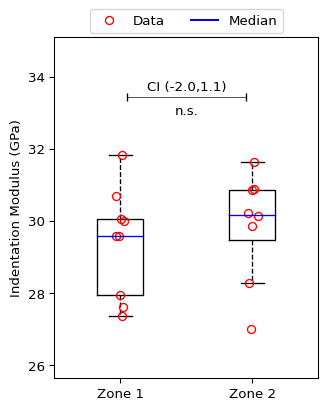

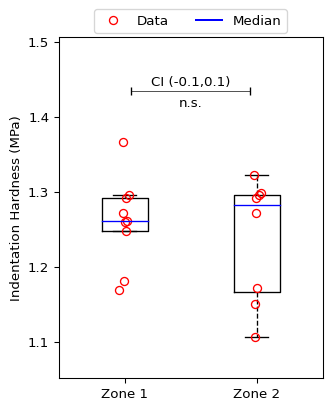

In [24]:
# Boxplot of separated regions/tissue type for sample 1
Areas = [Data1.loc[Data1.index < 10],
         Data1.loc[Data1.index > 9]]
BoxPlot([A[Parameters[0]] for A in Areas], Labels=['',Parameters[0]], SetsLabels=['Zone 1','Zone 2'], TTest=True)
BoxPlot([A[Parameters[1]] for A in Areas], Labels=['',Parameters[1]], SetsLabels=['Zone 1','Zone 2'], TTest=True)

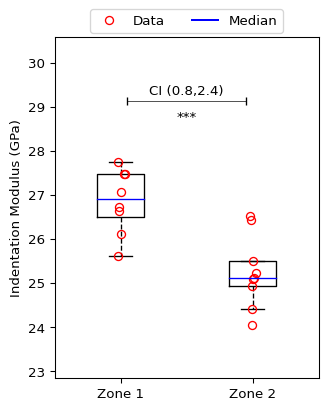

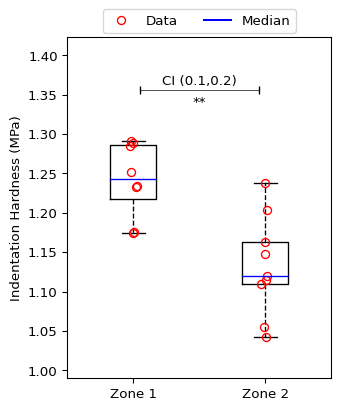

In [25]:
# Boxplot of separated regions/tissue type for sample 2
Areas = [Data2.loc[Data2.index < 10],
         Data2.loc[Data2.index > 9]]
BoxPlot([A[Parameters[0]] for A in Areas], Labels=['',Parameters[0]], SetsLabels=['Zone 1','Zone 2'], TTest=True)
BoxPlot([A[Parameters[1]] for A in Areas], Labels=['',Parameters[1]], SetsLabels=['Zone 1','Zone 2'], TTest=True)

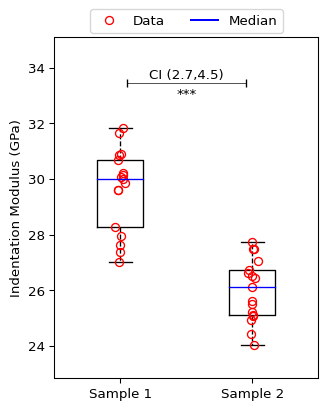

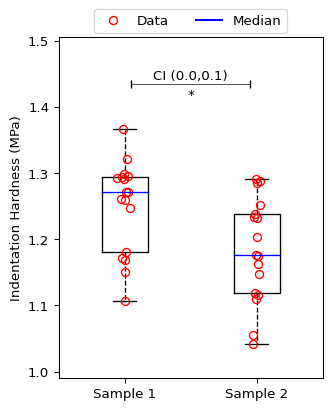

In [26]:
# Boxplot of the two samples properties
Sample = [Data1, Data2]
BoxPlot([S[Parameters[0]] for S in Sample], Labels=['',Parameters[0]], SetsLabels=['Sample 1','Sample 2'], TTest=True)
BoxPlot([S[Parameters[1]] for S in Sample], Labels=['',Parameters[1]], SetsLabels=['Sample 1','Sample 2'], TTest=True)

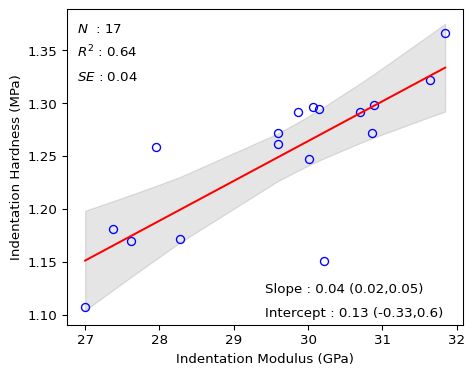

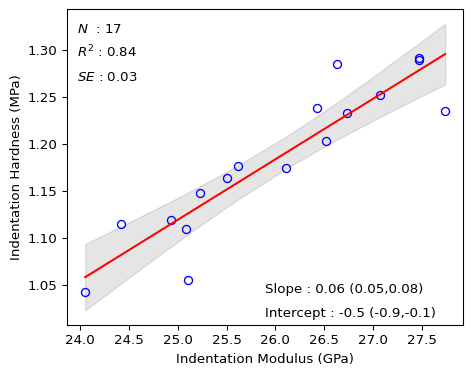

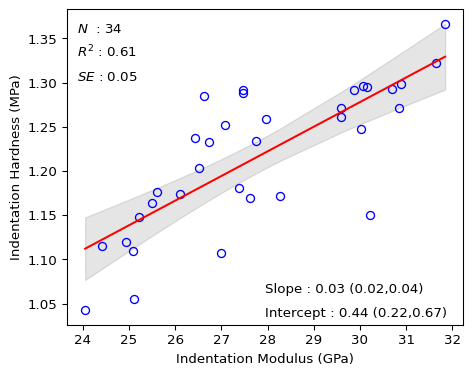

In [27]:
# Plot linear regression between hardness and modulus
X1 = np.array(Data1[Parameters[0]],float)
Y1 = np.array(Data1[Parameters[1]],float)
OLS(X1,Y1, Labels=[Parameters[0], Parameters[1]])

X2 = np.array(Data2[Parameters[0]],float)
Y2 = np.array(Data2[Parameters[1]],float)
OLS(X2,Y2, Labels=[Parameters[0], Parameters[1]])

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])
OLS(X,Y, Labels=[Parameters[0], Parameters[1]])